In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import os
import glob
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
import cv2
import gaitFunctions
from gaitFunctions import pairwiseStats
import combineClips
import plotClip
def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#a665c9'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# control vs. experimental colors
cmap = 'PiYG_r'

def getLevelColor(cmap,level):
    colormap = mpl.colormaps[cmap]
    level_boundaries = np.linspace(-0.95,0.95,20)
    cmap_levels = np.linspace(0,1,21)
    
    for i, boundary in enumerate(level_boundaries):
        if level <= boundary:
            return colormap(cmap_levels[i])
        
    return colormap(cmap_levels[-1])

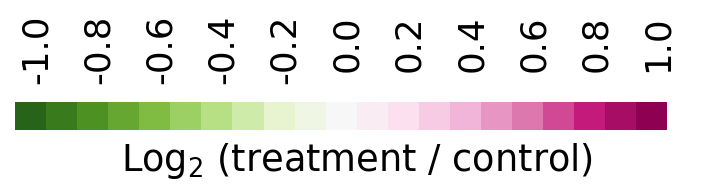

In [3]:
# horizontal map

levels = np.linspace(-1,1,21)
xlevel = 0
f,ax = plt.subplots(figsize=(5.88,1.96), dpi=150, facecolor=(1,1,1,0)) # was (3,1)
for i, level in enumerate(levels):
    square_color = getLevelColor(cmap, level)
    square = patches.Rectangle((xlevel, 0.1), 1, 1, linewidth=0.1, edgecolor=None, facecolor=square_color)        
    ax.add_patch(square)
    tenx = int(np.round(level*10,1))
    if tenx % 2 == 0:
        ax.text(xlevel+0.15,3.8,str(np.round(level,1)), rotation=90, 
                verticalalignment='top',fontsize=tick_fontsize*1.9)
    xlevel += 1
ax.set_xlabel('Log$_{2}$ (treatment / control)')
ax.set_xlim([0,len(levels)+1])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.set_aspect('equal')
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.label.set_size(tick_fontsize)
ax.xaxis.label.set_size(tick_fontsize*1.96)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax.set_axis_off()

plt.show()

In [4]:
# load data from existing excel file
excel_filename = 'exemplaris_v_ramazzottius.xlsx'
path_summaries_df = pd.read_excel(excel_filename, sheet_name='path_summaries', index_col=None)
step_timing_df = pd.read_excel(excel_filename, sheet_name='step_timing', index_col=None)
step_summaries_df = pd.read_excel(excel_filename, sheet_name='step_summaries', index_col=None)
gait_summaries_df = pd.read_excel(excel_filename, sheet_name='gait_summaries', index_col=None)
gait_styles_speeds_df = pd.read_excel(excel_filename, sheet_name='gait_speeds', index_col=None)
control = 'exemplaris'
experimental = 'ramazzottius'

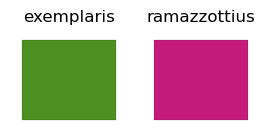

In [5]:
# control and experimental colors
col_level = 0.8
con_color = getLevelColor('PiYG_r', -col_level)
exp_color = getLevelColor('PiYG_r', col_level)
palette = [con_color,exp_color]

f,[ax1,ax2] = plt.subplots(1,2,figsize=(2.8,1.5))
con_square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=con_color)        
ax1.add_patch(con_square)
ax1.axis('off')
ax1.set_title(control)

exp_square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=exp_color)        
ax2.add_patch(exp_square)
ax2.axis('off')
ax2.set_title(experimental)

plt.tight_layout()
plt.show()

# examine values for a column (e.g. to look for outliers)

Looking at  Body Length (mm)
full set: 127
exemplaris 103 0.25152854289991644
ramazzottius 24 0.22478822352618666


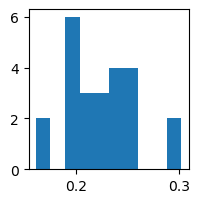

,Identifier,Body Length (mm),treatment
3,jc_14sep_tardigrade01_ramazzottius,0.205943,ramazzottius
7,sp_14sep_tardigrade03_ramazzottius,0.210528,ramazzottius
2,hp_14sep_tardigrade02_ramazzottius,0.212864,ramazzottius
12,jc_21sep_tardigrade03_ramazzottius,0.217721,ramazzottius
18,rm_21sep_tardigrade03_ramazzottius,0.227475,ramazzottius
16,rm_21sep_tardigrade01_ramazzottius,0.227799,ramazzottius
13,jc_21sep_tardigrade04_ramazzottius,0.237268,ramazzottius
1,hp_14sep_tardigrade01_ramazzottius,0.239175,ramazzottius


In [6]:
# col = 'Speed (body lengths / sec cruising)'
col = 'Body Length (mm)'
print('Looking at ', col)
df = path_summaries_df[['Identifier',col,'treatment']]
print('full set:', len(df))
c_vals = df[df['treatment']==control][col].values
c_mean = np.nanmean(c_vals)
print(control, len(c_vals), c_mean)
e_vals = df[df['treatment']!=control][col].values
e_mean = np.nanmean(e_vals)
print(experimental, len(e_vals), e_mean)

# show a histogram for this column
toshow_df = df[df['treatment']==experimental] # experimental or control
f = plt.figure(figsize=(2,2))
a=f.add_axes([0.1,0.1,0.8,0.8])
plt.hist(toshow_df[col].values)
plt.show()

# show a bit of dataframe around halfway point to find 'average' individual
halfpoint = int(len(toshow_df)/2)
buffer = 4
toshow_df.sort_values(by=col).head(halfpoint+buffer).tail(2*buffer) # .head(half + some).tail(some)


In [7]:
treatments = [experimental,control]
for t in treatments:
    vals = df[df['treatment']==t][col].values
    print('max', t, np.max(vals))
    print('mean', t, np.mean(vals))
    print('min', t, np.min(vals))
    print('n',t,'=', len(vals))
    print()

max ramazzottius 0.3019690701895755
mean ramazzottius 0.22478822352618666
min ramazzottius 0.1610359689146263
n ramazzottius = 24

max exemplaris 0.3264368001249307
mean exemplaris 0.25152854289991644
min exemplaris 0.1925400023831821
n exemplaris = 103



# Selecting data to analyze

In [8]:
# Path Data
print(path_summaries_df.columns)
path_cols =[
#     'Body Size (mm^2)', 
    'Body Length (mm)',
#     'Body Width (mm)', 
    'Body Width/Length Ratio', 
#     'Duration analyzed (sec)',
#     'Distance traveled (mm)', 
    'Percentage of time cruising', # this is basically body length / sec, and inverse of stops / sec
#     'Speed (mm/sec)',
    'Speed (body lengths / sec)', 
#     'Speed (mm/sec cruising)', 
    'Speed (body lengths / sec cruising)',
#     'Total bearing change (deg)', 
#     'Bearing change (deg) / sec',
    'Bearing change (deg) / sec cruising', 
#     'Number of stops', 
#     'Stops / sec', # this is basically just the inverse of % cruising
#     'Number of turns', 
#     'Turns / sec'
]
print(len(path_cols))

Index(['Identifier', 'treatment', 'individual', 'date',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec'],
      dtype='object')
6


In [9]:
# STEP KINEMATICS
# print(step_summaries_df.columns) 
step_cols = [
    'Stance duration (lateral legs)', 
    'Swing duration (lateral legs)',
#     'Gait cycle (lateral legs)', 
#     'Duty factor (lateral legs)',
    'mm per step (lateral legs)', 
    'bodylength per step (lateral legs)',
    'Stance duration (rear legs)', 
    'Swing duration (rear legs)',
#     'Gait cycle (rear legs)', 
#     'Duty factor (rear legs)',
#     'mm per step (rear legs)', 
    'bodylength per step (rear legs)', 
#     'Metachronal lag (lateral legs)',
#     'Metachronal lag (normalized, lateral legs)',
#     'Metachronal lag Abs (Left-Right Ratio)',
#     'Metachronal lag ratios per L3 step', # transformed this to
    'Abs MCL Ratio per L3',
#     'Bearing change per L3 step',
#     'Anterior swing offsets (lateral legs)',
    'Anterior swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (lateral legs)',
    'Opposite swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (rear legs)',
    'Opposite swing offsets (normalized, rear legs)']
print(len(step_cols))

11


In [10]:
# GAIT STYLES
# print(gait_summaries_df.columns)
gait_cols = [
#     '% stand (lateral legs)',
#     '% pentapod (lateral legs)',
    '% tetrapod canonical (lateral legs)',
#     '% tetrapod gallop (lateral legs)', 
#     '% tetrapod other (lateral legs)',
#     '% tetrapod total (lateral legs)', 
    '% tripod canonical (lateral legs)',
#     '% tripod other (lateral legs)', 
#     '% tripod total (lateral legs',
#     '% other (lateral legs)',
#     '% stand (rear legs)', 
#     '% hop (rear legs)',
    '% step (rear legs)',
    'Tetrapod Coordination Strength',
#     'Tetrapod Bout Speed (bodylength / s)',
    'Tripod Coordination Strength',
#     'Tripod Bout Speed (bodylength / s)'
#     'CLR tetrapod canonical (lateral legs)',
#     'CLR tripod canonical (lateral legs)',
#     'CLR step (rear legs)'
]
print(len(gait_cols))

5


# Exploring the data
What are correlations in all data? To see this, merge the dataframes
<br> ... but a problem with merging is that we OMIT anything that does not have step tracking!
<br> ... may need/want to keep these, especially if we are interest in (non-cruising) speed.

In [11]:
def mergeDataframes(dflist,col='Identifier'):
    df = dflist[0].copy()
    for i in np.arange(len(dflist[:-1])):
        df = df.merge(dflist[i+1],on=col)
    return df

def getDfForCol(col, dflist):
    for df in dflist:
        if col in df.columns:
            return df.copy()
    return None

In [12]:
merged_df = mergeDataframes([path_summaries_df, step_summaries_df, gait_summaries_df])
merged_df.columns

Index(['Identifier', 'treatment_x', 'individual_x', 'date_x',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec', 'treatment_y', 'individual_y',
       'Stance duration (lateral legs)', 'Swing duration (lateral legs)',
       'Gait cycle (lateral legs)', 'Duty factor (lateral legs)',
       'mm per step (lateral legs)', 'bodylength per step (lateral legs)',
       'Stance duration (rear legs)', 'Swing duration (rear legs)',
       'Gait cycle (rear legs)', 'Duty factor (rear legs)',
       'mm per step (rear legs)'

In [13]:
df = merged_df.copy() # merged_df or path_summaries_df step_summaries_df gait_summaries_df
analysis_cols = ['treatment'] + path_cols + step_cols + gait_cols
df = df[analysis_cols]

In [14]:
df.count()
# df.describe()

treatment                                            117
Body Length (mm)                                     117
Body Width/Length Ratio                              117
Percentage of time cruising                          117
Speed (body lengths / sec)                           117
Speed (body lengths / sec cruising)                  117
Bearing change (deg) / sec cruising                  117
Stance duration (lateral legs)                       117
Swing duration (lateral legs)                        117
mm per step (lateral legs)                           117
bodylength per step (lateral legs)                   117
Stance duration (rear legs)                          117
Swing duration (rear legs)                           117
bodylength per step (rear legs)                      117
Abs MCL Ratio per L3                                 117
Anterior swing offsets (normalized, lateral legs)    116
Opposite swing offsets (normalized, lateral legs)    116
Opposite swing offsets (normali

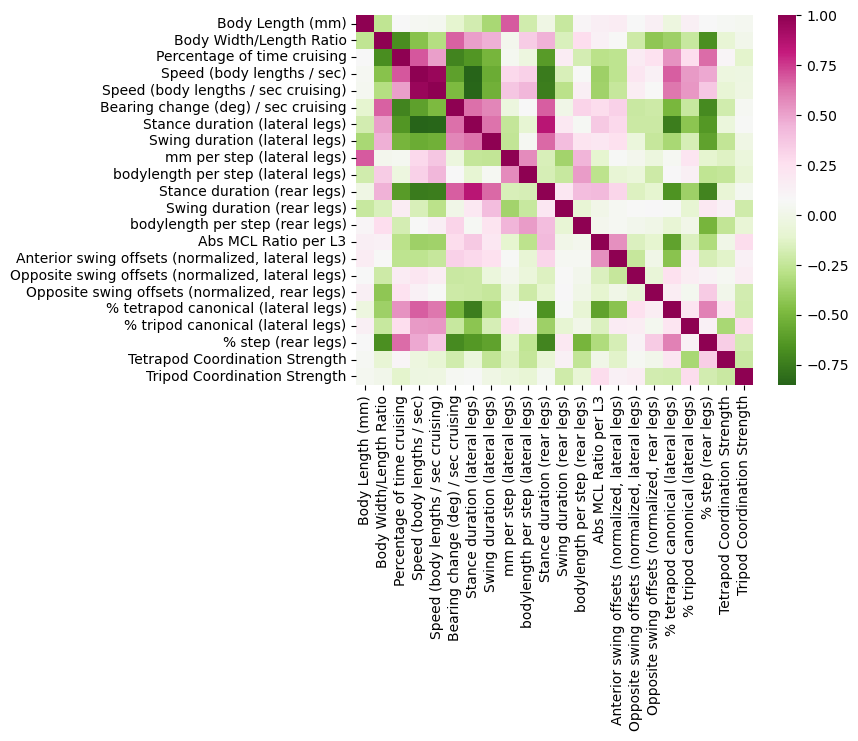

In [15]:
# looking for correlations within the dataset
comp_cols = path_cols+step_cols+gait_cols
df = merged_df[comp_cols]
corrmat = df.corr(numeric_only=True)
sns.heatmap(corrmat,cmap=cmap) # 'bwr' # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.show()

# Functions for pairwise boxplots and stats

Mann-Whitney U p-val 0.0001


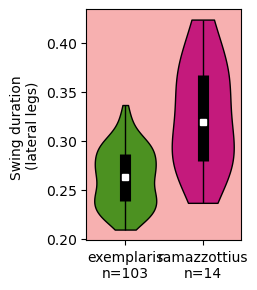

In [16]:
def compViolPlot(ax,df,col,pcolors,vwidth=0.8,scatter=True,medsize=5):
    
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
        
    xpos = [1,2]

    violins = ax.violinplot(data_to_plot, widths=vwidth, showmeans=False, showextrema=False)
    
    for i, pc in enumerate(violins['bodies']):
        pc.set_facecolor(pcolors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
        # add scatter over the violin
        if scatter:
            a = 0.7 # alpha
            sz = 4 # size
            sc = 'royalblue' # [ 0.76, 0.86, 0.85 ] # 'k' 'w' # marker color
            ji = 0.02 # jitter around midline
            xScatter = np.random.normal(1, ji, size=len(data_to_plot[i]))
            ax.scatter(xpos[i], data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
        # homemade box plot
        q1, median, q3 = np.percentile(data_to_plot[i], [25, 50, 75])
        vals = np.sort(data_to_plot[i])

        upper_adjacent_value = q3 + (q3 - q1) * 1.5
        upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

        lower_adjacent_value = q1 - (q3 - q1) * 1.5
        lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)

        whisk_min, whisk_max = lower_adjacent_value, upper_adjacent_value
        ax.vlines(xpos[i], whisk_min, whisk_max, color='k', linestyle='-', lw=1)
        ax.vlines(xpos[i], q1, q3, color='k', linestyle='-', lw=8)
        ax.plot(xpos[i],median,'sw',markersize=medsize)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)

    ax.set_xlim([0.5,2.5])
    
    return ax, data_to_plot

def compBoxPlot(ax,df,col): 
 
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
    
    # make boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, showfliers=False)
    bp = gaitFunctions.formatBoxPlots(bp, ['black'], ['whitesmoke'], ['dimgrey'])
    
    # add scatter over the boxplot
    a = 1 # alpha
    sc = 'silver' # [ 0.76, 0.86, 0.85 ] # 'k' # color
    sz = 5 # marker size
    ji = 0.02 # jitter around midline
    for i, group in enumerate(groupnames):   
        xScatter = np.random.normal(i+1, ji, size=len(data_to_plot[i]))
        ax.scatter(xScatter, data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)
    
    return ax, data_to_plot

def correctMultipleTests(ps,method): # method is 'bonferroni' or 'benjamini-hochberg' or 'benjamini-yekutieli'
    if method == 'bonferroni':
        adj_ps = [x*len(ps) for x in ps]
    elif method == 'benjamini-hochberg' or method == 'bh':
        adj_ps = [x for x in stats.false_discovery_control(ps)]
    elif method == 'benjamini-yekutieli' or method == 'by':
        adj_ps = [x for x in stats.false_discovery_control(ps, method='by')]
    else:
        print('No pvalue adjustment')
        adj_ps = ps
    return adj_ps

def facecolorPval(ax,pval):
    
    if pval < 0.001:
        fc = '#f7b0b0' # pinkish
    elif pval < 0.01:
        fc = '#fcca74' # orange-ish
    elif pval < 0.05:
        fc = '#f6f7a1' # yellow-ish
    else:
        fc = 'white'
    
    ax.set_facecolor(fc)

    return ax

def boxArray(maxcols,df,to_compare):

    if len(to_compare) % maxcols == 0:
        numrows = int(len(to_compare) / maxcols)
        cushion = 0
    else:
        numrows = int(len(to_compare) / maxcols) + 1
        cushion = maxcols - (len(to_compare) % maxcols)
    rows,cols = [numrows,maxcols]
    f,axes = plt.subplots(rows,cols,figsize = (8,2*numrows))
    axes_list = axes.reshape(1,len(to_compare)+cushion)[0]
    pvals = []
    tests = []
    for i, col in enumerate(to_compare):
        axes_list[i], data_to_plot = compBoxPlot(axes_list[i], df, col)
        pval,test = pairwiseStats(data_to_plot)# ,'kw')
        pvals.append(pval)
        tests.append(test)
        axes_list[i].yaxis.label.set_size(tick_fontsize)
        axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    for i in np.arange(cushion):
        axes_list[-(i+1)].set_axis_off()
    print(tests)
    print('pvals         ',[np.round(x,3) for x in pvals])

    # adjust p-values for multiple hypothesis testing
    adj_ps = correctMultipleTests(pvals,'by') # 'bonferroni' or 'bh' or 'by'
    print('adjusted pvals',[np.round(x,3) for x in adj_ps])

    # recolor axes based on p-vals
    if cushion != 0:
        axes_list = axes_list[:-cushion]
    for i, ax in enumerate(axes_list):
        ax = facecolorPval(ax,adj_ps[i])

    plt.tight_layout()
    plt.show()

# test comparison plot
f,ax = plt.subplots(1,1,figsize=(2,3))
col = 'Swing duration (lateral legs)'# 
# col = 'Body Length (mm)'
df = getDfForCol(col,[path_summaries_df,step_summaries_df,gait_summaries_df])

# box plot comparison
# ax, data_to_plot = compBoxPlot(ax,df,col)

# violin plot comparison
ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)

pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
control_n = len(df[df['treatment']==control])
exp_n = len(df[df['treatment']==experimental])
ax.set_xticks([1,2],[control+'\nn='+str(control_n),experimental+'\nn='+str(exp_n)]) # comment off if want default ticks
print(test, 'p-val', np.round(pval,4))
plt.show()

T-test p-val 0.0


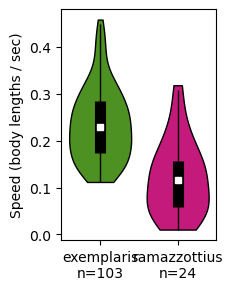

In [17]:
col = 'Speed (body lengths / sec)' # 'Speed (body lengths / sec cruising)' # 
f,ax = plt.subplots(1,1,figsize=(2,3))
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)
pval, test = pairwiseStats(data_to_plot)
# ax = facecolorPval(ax,pval) # comment off for no p-value color coding
print(test, 'p-val', np.round(pval,7))
control_n = len(df[df['treatment']==control])
exp_n = len(df[df['treatment']==experimental])
ax.set_xticks([1,2],[control+'\nn='+str(control_n),experimental+'\nn='+str(exp_n)]) # comment off if want default ticks
plt.show()

T-test p-val 0.0004588


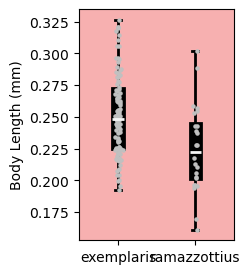

In [18]:
col = 'Body Length (mm)' # 'Body Length (mm)' # 
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
f,ax = plt.subplots(1,1,figsize=(2,3))
ax, data_to_plot = compBoxPlot(ax,df,col)
pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
print(test, 'p-val', np.round(pval,7))
plt.show()

# Arrays of boxplots

['T-test', 'Mann-Whitney U', 'Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'T-test']
pvals          [0.0, 0.0, 0.0, 0.0, 0.18, 0.0]
adjusted pvals [0.001, 0.0, 0.0, 0.0, 0.442, 0.0]


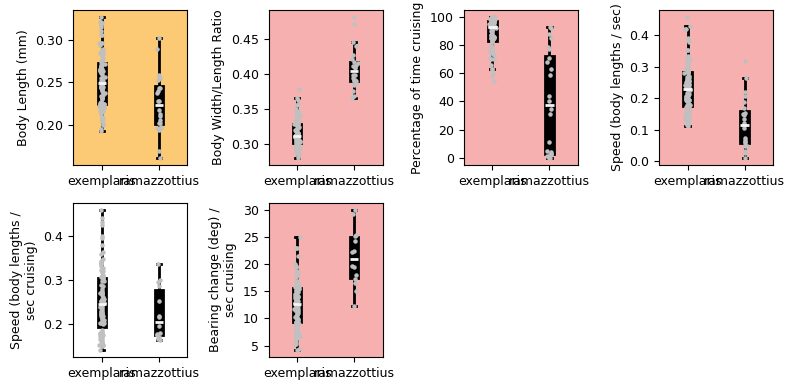

In [19]:
boxArray(4,path_summaries_df,path_cols)

['T-test', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'T-test', 'T-test', 'Mann-Whitney U', 'Mann-Whitney U']
pvals          [0.0, 0.0, 0.791, 0.0, 0.004, 0.894, 0.008, 0.761, 0.803, 0.649, 0.096]
adjusted pvals [0.0, 0.001, 1.0, 0.0, 0.034, 1.0, 0.055, 1.0, 1.0, 1.0, 0.533]


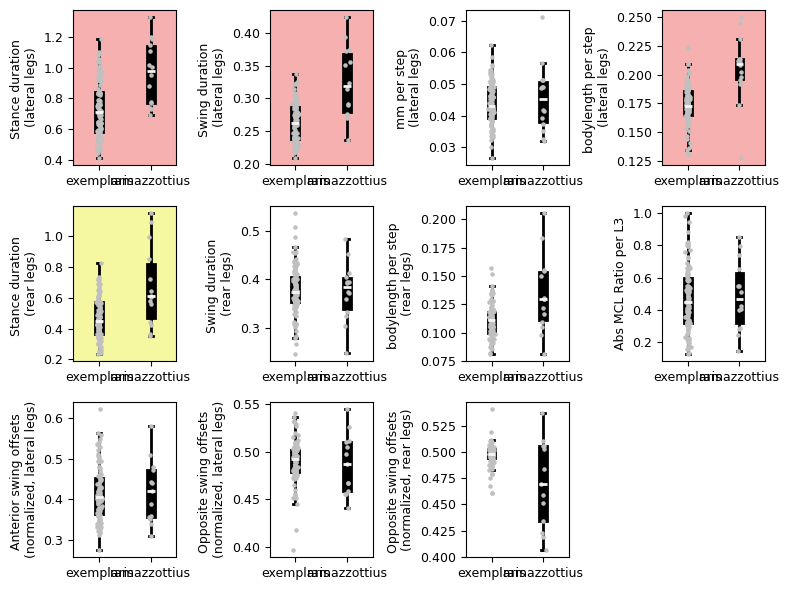

In [20]:
boxArray(4,step_summaries_df,step_cols)

['T-test', 'Mann-Whitney U', 'Mann-Whitney U', 'T-test', 'Mann-Whitney U']
pvals          [0.01, 0.467, 0.0, 0.075, 0.78]
adjusted pvals [0.059, 1.0, 0.0, 0.286, 1.0]


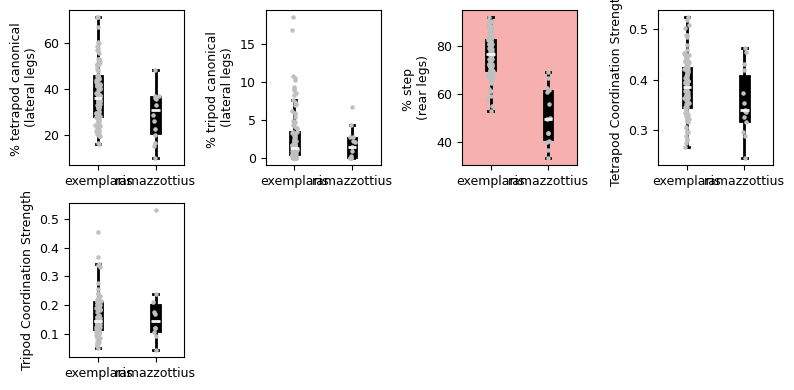

In [21]:
boxArray(4,gait_summaries_df,gait_cols)

# Phenotype Heatmaps and Multiple Comparisons

In [22]:
# which data to compare
# colraw = path_cols + step_cols + gait_cols # get them all from above

# or manually set
colraw  = ['Body Length (mm)', 
           'Speed (body lengths / sec)',
#            'Body Width/Length Ratio', 
           'Percentage of time cruising', 
           'Speed (mm/sec cruising)', 
           'Speed (body lengths / sec cruising)', 
           'Bearing change (deg) / sec cruising', 
           'Stance duration (lateral legs)', 
           'Swing duration (lateral legs)', 
           'mm per step (lateral legs)', 
           'bodylength per step (lateral legs)', 
           'Stance duration (rear legs)', 
           'Swing duration (rear legs)', 
#            'bodylength per step (rear legs)', 
           'Abs MCL Ratio per L3', 
           'Anterior swing offsets (normalized, lateral legs)', 
           'Opposite swing offsets (normalized, lateral legs)', 
           'Opposite swing offsets (normalized, rear legs)', 
           '% tetrapod canonical (lateral legs)',
           'Tetrapod Coordination Strength',
           '% tripod canonical (lateral legs)', 
           'Tripod Coordination Strength',
           '% step (rear legs)', 
           ]


In [23]:
# Clean up category labels for heatmap plot

collablist = [
'Body Length',
'Body Length / sec overall',
# 'Body Width/Length Ratio',
'% sustained walking',
'mm / sec walking',
'Body Length / sec walking',
'Δ˚ / sec walking',
'Stance duration (lat)',
'Swing duration (lat)',
'mm / step (lat)',
'Body Length / step (lat)',
'Stance duration (rear)',
'Swing duration (rear)',
# 'Body Length / step (rear)',
'MCL logratio L3/R3',
'ϕi (lateral)',
'ϕc (lateral)',
'ϕc (rear)',
'% tetrapod canonical',
'Tetrapod CS',
'% tripod canonical',
'Tripod CS',
'% step (rear)'
]

collabs = dict(zip(colraw,collablist))
# be sure we have the right labels
for k in collabs.keys():
    print(k, '-->', collabs[k])

Body Length (mm) --> Body Length
Speed (body lengths / sec) --> Body Length / sec overall
Percentage of time cruising --> % sustained walking
Speed (mm/sec cruising) --> mm / sec walking
Speed (body lengths / sec cruising) --> Body Length / sec walking
Bearing change (deg) / sec cruising --> Δ˚ / sec walking
Stance duration (lateral legs) --> Stance duration (lat)
Swing duration (lateral legs) --> Swing duration (lat)
mm per step (lateral legs) --> mm / step (lat)
bodylength per step (lateral legs) --> Body Length / step (lat)
Stance duration (rear legs) --> Stance duration (rear)
Swing duration (rear legs) --> Swing duration (rear)
Abs MCL Ratio per L3 --> MCL logratio L3/R3
Anterior swing offsets (normalized, lateral legs) --> ϕi (lateral)
Opposite swing offsets (normalized, lateral legs) --> ϕc (lateral)
Opposite swing offsets (normalized, rear legs) --> ϕc (rear)
% tetrapod canonical (lateral legs) --> % tetrapod canonical
Tetrapod Coordination Strength --> Tetrapod CS
% tripod can


label, log2ratio, adjusted pval, test
Body Length (mm) -0.16215566723820368 0.004390027449083324 T-test
Speed (body lengths / sec) -0.965668655596488 5.120217076720809e-08 T-test
Percentage of time cruising -1.1588577705535674 2.6366344753936955e-08 Mann-Whitney U
Speed (mm/sec cruising) -0.34418097472479786 0.1349815189593216 T-test
Speed (body lengths / sec cruising) -0.17545500788957508 0.9865600893726693 Mann-Whitney U
Bearing change (deg) / sec cruising 0.7481249869657928 2.6366344753936955e-08 T-test
Stance duration (lateral legs) 0.4187792440263867 0.00014444401912870565 T-test
Swing duration (lateral legs) 0.30536098000524575 0.0008504700947476161 Mann-Whitney U
mm per step (lateral legs) 0.051104282106273526 1.0 Mann-Whitney U
bodylength per step (lateral legs) 0.23267923589542405 0.00018388780746700264 Mann-Whitney U
Stance duration (rear legs) 0.5171398863807833 0.03515126493546745 Mann-Whitney U
Swing duration (rear legs) -0.007265107874109254 1.0 T-test
Abs MCL Ratio per 

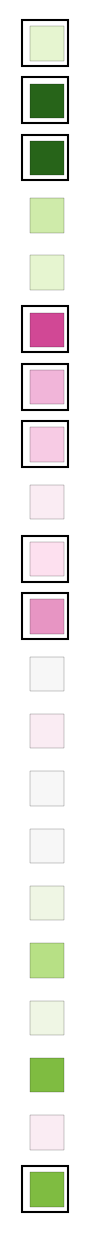

In [24]:
# function for Z-scores, log ratio plots, and combining dataframes
def pairZscore(data,conditions): # I do not use this function anywhere
    # data is a vector of numbers for control and experimental treatments
    # conditions is a vector of 0 and 1 (for pairs), where
    # 'control' is assumed to be 0
    control_data = data[np.where(conditions==0)]
    exp_data = data[np.where(conditions==1)]
    control_mean = np.nanmean(control_data)
    control_std = np.nanstd(control_data)
    exp_std = np.nanstd(exp_data)
    zscores = np.zeros(len(data))
    for i, d in enumerate(data):
        if conditions[i] == 0: # control!
            zscores[i] = (d-control_mean)/control_std
        elif conditions[i] == 1:
            zscores[i] = (d-control_mean)/exp_std
    return zscores

def ratioPlot(ax, dflist, colslist, collabs, control='control', cmap='bwr', plotLabels = True):
    '''
    Parameters
    
    dflist: a list of dataframes, usually path_summaries_df, step_summaries_df, gait_summaries_df
         or pdf, sdf, gdf
    colslist: a list columns within these dataframes
    '''

    # find total number of comparisons
    total_cols = len(colslist)
    
    # make empty containers for log ratios and pvals and labels
    control_means = np.zeros(total_cols)
    control_stds = np.zeros(total_cols)
    exp_means = np.zeros(total_cols)
    exp_stds = np.zeros(total_cols)
    log2ratios = np.zeros(total_cols)
    pvals = np.zeros(total_cols)
    tests = np.empty(total_cols, dtype='object')
    labels = np.empty(total_cols, dtype='object')
    idx = 0 # index for these containers
    
    # go through list of columns to analyze
    for i, column in enumerate(colslist):
        
        df = getDfForCol(column, dflist)

        # set control to 0 and experimental to 1
        df['Condition'] = np.where(df['treatment'] == control, 0, 1)
        conditions = df['Condition'].values

        # get the data for that column
        data = df[column].values
        control_data = data[np.where(conditions==0)]
        exp_data = data[np.where(conditions==1)]

        # remove nan (no data)
        control_data = control_data[~np.isnan(control_data)]
        exp_data = exp_data[~np.isnan(exp_data)]
        
        # get and save mean and std
        control_means[i] = np.mean(control_data)
        control_stds[i] = np.std(control_data)
        exp_means[i] = np.mean(exp_data)
        exp_stds[i] = np.std(exp_data)

        # get pval for this column            
        pval, test = pairwiseStats([control_data, exp_data])
#       print(column, pval, test) # testing
        pvals[i] = pval
        tests[i] = test

        # get label for this column
        labels[i] = column

        # get log2(experiment/control) ratio for this column (CLR causes trouble!)
        log2ratios[i] = np.log2(np.mean(exp_data)/np.mean(control_data))          

    # correct pvals for multiple comparisons
    adj_pvals = correctMultipleTests(pvals,'by')
    
    ytext = 0.25 # level for text above the lower edge of each square

    ylevel = len(labels) + 1
    
    big_box = 0.4
    small_box = 0.3

    # go through data
    for i, label in enumerate(labels):
    
        # plot a square, with color scaled to log2_ratio
        square_color = getLevelColor(cmap, log2ratios[i])
        
        square_center_x = 0.53
        square_center_y = ylevel + 0.505
        
        # plot a box around square if significant
        if adj_pvals[i] < 0.05:
            linewidth = 0.1 # 0.1 or 3 or 5
            ec = 'k'
#             ax.text(0.25,ylevel,s='*',fontsize=axis_fontsize) # or comment out
            square = patches.Rectangle((square_center_x-big_box, square_center_y-big_box), 
                                       2*big_box, 2*big_box, linewidth=1, edgecolor='k', facecolor='w')        
            ax.add_patch(square)
        else:
            linewidth = 0.1
            ec = 'k'
        
        square = patches.Rectangle((square_center_x-small_box+0.025, square_center_y-small_box-0.01), 
                                   2*small_box, 2*small_box, linewidth=linewidth, 
                                   edgecolor=ec, facecolor=square_color)        
        ax.add_patch(square)
        
        # plot the text
        if plotLabels:
#             label = label.replace('normalized, ','')
#             label = label.replace(' legs','')
            ax.text(1.1,ylevel+ytext,s=collabs[label],fontsize=tick_fontsize, horizontalalignment='left')

        # plot horizontal lines to separate the different dataframes ?
        
        # update ylevel
        ylevel = ylevel-1

    ax.set_ylim([2,len(labels) + 2])
    ax.set_aspect('equal')
#     ax.set_xlim([0,1])
    ax.set_axis_off()
    return ax, control_means, control_stds, exp_means, exp_stds, log2ratios, pvals, adj_pvals, tests, labels

dfs = [path_summaries_df, step_summaries_df, gait_summaries_df]
f,ax = plt.subplots(figsize=(3.93,10.42), dpi=150, facecolor=(1,1,1,0)) # was 2, 5.3
print()
output = ratioPlot(ax, dfs, colraw, collabs, control, cmap, False) # False to hide labels on heatmap
[ax, control_means, control_stds, exp_means, exp_stds, log2_ratios, pvals, adj_pvals, tests, comp_labels] = output

# add label for comparison
comparison= control + ' vs. ' + experimental
# ax.text(0.1,1.7,s=comparison,rotation=270,fontsize=tick_fontsize, verticalalignment='top')

pval_dict = dict(zip(comp_labels,pvals))
adj_pval_dict = dict(zip(comp_labels,adj_pvals))
test_dict = dict(zip(comp_labels,tests))
print('label, log2ratio, adjusted pval, test')
for i, lab in enumerate(comp_labels):
    print(lab, log2_ratios[i], adj_pval_dict[lab], test_dict[lab])
plt.show()

In [25]:
# Table of values to save!
from decimal import Decimal
'%.2E' % Decimal('40800000000.00000000000000')

control_means = [np.round(x,2) for x in control_means]
control_stds = [np.round(x,2) for x in control_stds]
exp_means = [np.round(x,2) for x in exp_means]
exp_stds = [np.round(x,2) for x in exp_stds]
log2_ratios = [np.round(x,2) for x in log2_ratios]

control_col = control + ' Mean ± Std'
experimental_col = experimental + ' Mean ± Std'
logratio_col = 'log2 ratio ' + experimental + '/' + control
adj_pvals = ['%.2E' % Decimal(adj_pval_dict[x]) for x in comp_labels]

control_meanstd = [str(m) + ' ± ' + str(control_stds[i]) for i,m in enumerate(control_means)]
exp_meanstd = [str(m) + ' ± ' + str(exp_stds[i]) for i,m in enumerate(exp_means)]

summary_df = pd.DataFrame({'Measurement':comp_labels,
                          control_col:control_meanstd,
                          experimental_col:exp_meanstd,
                           logratio_col:log2_ratios,
                           'Adjusted p-value':adj_pvals,
                           'Test':tests
                          })
blankIndex=[''] * len(summary_df)
summary_df.index=blankIndex
disp_cols = ['Measurement',control_col, experimental_col, logratio_col, 'Adjusted p-value','Test']
display(summary_df[disp_cols])

,Measurement,exemplaris Mean ± Std,ramazzottius Mean ± Std,log2 ratio ramazzottius/exemplaris,Adjusted p-value,Test
,Body Length (mm),0.25 ± 0.03,0.22 ± 0.03,-0.16,4.39E-03,T-test
,Speed (body lengths / sec),0.23 ± 0.08,0.12 ± 0.08,-0.97,5.12E-08,T-test
,Percentage of time cruising,88.68 ± 10.93,39.72 ± 34.97,-1.16,2.64E-08,Mann-Whitney U
,Speed (mm/sec cruising),0.06 ± 0.02,0.05 ± 0.02,-0.34,1.35E-01,T-test
,Speed (body lengths / sec cruising),0.25 ± 0.07,0.22 ± 0.06,-0.18,9.87E-01,Mann-Whitney U
,Bearing change (deg) / sec cruising,12.62 ± 4.31,21.19 ± 5.06,0.75,2.64E-08,T-test
,Stance duration (lateral legs),0.72 ± 0.18,0.97 ± 0.2,0.42,1.44E-04,T-test
,Swing duration (lateral legs),0.26 ± 0.03,0.32 ± 0.05,0.31,8.50E-04,Mann-Whitney U
,mm per step (lateral legs),0.04 ± 0.01,0.05 ± 0.01,0.05,1.00E+00,Mann-Whitney U
,bodylength per step (lateral legs),0.17 ± 0.02,0.21 ± 0.03,0.23,1.84E-04,Mann-Whitney U


# graphs for a particular comparison of interest

exemplaris n = 103
ramazzottius n = 14
T-test p-val 9.4e-06
Adjusted p-val 0.0001444


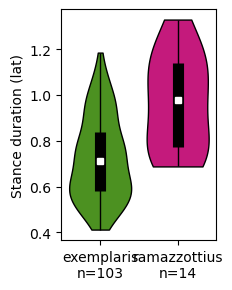

In [26]:
# violin plots
diffcols = ['Body Length (mm)', # 0
            'Body Width/Length Ratio', # 1
           'bodylength per step (lateral legs)', # 2
           'Bearing change (deg) / sec cruising', # 3
           'Stops / sec', # 4
           'Stance duration (lateral legs)', # 5
            'Swing duration (lateral legs)', # 6
            'bodylength per step (lateral legs)', # 7
            'Stance duration (rear legs)', # 8
            '% step (rear legs)' # 9
           ]

col =  diffcols[5] # <----- change this index for different columns
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
df['Condition'] = np.where(df['treatment'] == control, 0, 1)

f,ax = plt.subplots(1,1,figsize=(2,3))
controln = len(df[df['Condition']==0][col].values)
expn = len(df[df['Condition']==1][col].values)

control_lab = control + '\nn=' + str(controln)
exp_lab = experimental + '\nn=' + str(expn)

print(control,'n =', controln)
print(experimental,'n =',expn)

ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)
ax.set_ylabel(collabs[col])
pval, test = pairwiseStats(data_to_plot)
apval = adj_pval_dict[col]
# ax = facecolorPval(ax,pval) # comment off for no p-value color coding
print(test, 'p-val', np.round(pval,7))
print('Adjusted p-val', np.round(apval,7))
ax.set_xticks([1,2],[control_lab, exp_lab]) # comment off if want default ticks
plt.show()

# ICP composition comparisons

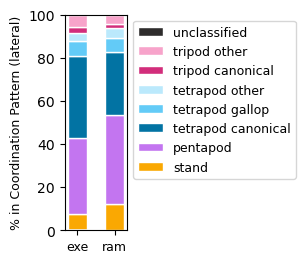

In [27]:
def gaitStylePercentagesPlot(ax, df, control='control', leg_set='lateral', addLegend=True):
    
    barWidth = 0.5
    df = df.copy()
    ylab = 'Percentage in Gait Style'

    # set up colors
    if leg_set in ['rear','two','human']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('rear')
        columns = ['% stand (rear legs)', '% step (rear legs)','% hop (rear legs)']
        ylab += '\n(Rear Legs)'
    elif leg_set in ['four','cat','dog','tetrapod']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('four')
    elif leg_set in ['lateral','insect','six']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
        columns = [x for x in df.columns if '%' in x]
        columns = [x for x in columns if 'lateral' in x]
        columns = [x for x in columns if 'total' not in x]
        ylab += '\n(Lateral Legs)'
#     print(combo_colors) # test OK
#     print(columns) # test OK
    
    # set control to 0 and experimental to 1
    df['Condition'] = np.where(df['treatment'] == control, 0, 1)
    conditions = df['Condition'].values
    exp_name = np.unique(df.treatment.values[np.where(conditions==1)])[0]
#     print(exp_name)
  
    bottoms = [0,0]
    for c, column in enumerate(columns):
        data = df[column].values
        control_mean = np.mean(data[np.where(conditions==0)])
        exp_mean = np.mean(data[np.where(conditions==1)])
        for i, val in enumerate([control_mean, exp_mean]):
            if i == 0: # plot for legend
                ax.bar(i, 0, bottom = 0, color = combo_colors[all_combos[c]],
                       edgecolor='white', width=barWidth, label=all_combos[c].replace('_',' '))
            ax.bar(i, val, bottom=bottoms[i], color=combo_colors[all_combos[c]],
                  edgecolor='white',width=barWidth)
            bottoms[i] += val
    
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels([control, exp_name], fontsize=tick_fontsize, rotation=90)
    
    # Add a legend
    if addLegend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='upper left',
                  bbox_to_anchor=(1,1), ncol=1, fontsize=tick_fontsize)
        ax.set_ylabel(ylab, fontsize=axis_fontsize)
    ax.set_ylim([0,100]) 

    return ax

df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'lateral', True) # False to hide legend and Y label
ax.set_xticks([0,1],[control[:3],experimental[:3]],rotation=0)
ax.set_ylabel('% in Coordination Pattern (lateral)',fontsize=tick_fontsize)
plt.show()

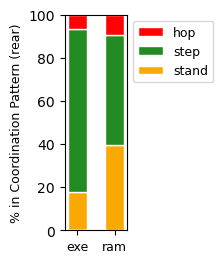

In [28]:
df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'rear', True) # False to hide legend and Y label
ax.set_xticks([0,1],[control[:3],experimental[:3]],rotation=0)
ax.set_ylabel('% in Coordination Pattern (rear)',fontsize=tick_fontsize)
plt.show()

# ternary plots and compositional statistics

In [29]:
from gaitFunctions import colorBoxplot
from gaitFunctions import pairwiseStats
import mpltern
import composition_stats as cs
gait_summaries_df.head(5)

,Identifier,treatment,individual,date,Number of frames,% stand (lateral legs),% pentapod (lateral legs),% tetrapod canonical (lateral legs),% tetrapod gallop (lateral legs),% tetrapod other (lateral legs),...,CLR pentapod (lateral legs),CLR tetrapod canonical (lateral legs),CLR tetrapod gallop (lateral legs),CLR tetrapod other (lateral legs),CLR tripod canonical (lateral legs),CLR tripod other (lateral legs),CLR other (lateral legs),CLR stand (rear legs),CLR step (rear legs),CLR hop (rear legs)
0,hp_14sep_tardigrade01_ramazzottius,ramazzottius,tardigrade01,14sep,357,2.240896,24.089636,36.694678,8.123249,11.764706,...,-0.565099,0.154793,1.745756,1.685388,1.965275,2.297787,1.960805,-0.074672,-0.153803,1.217059
1,hp_14sep_tardigrade02_ramazzottius,ramazzottius,tardigrade02,14sep,428,11.915888,48.130841,26.401869,2.803738,7.009346,...,0.127043,-0.174404,0.681980,1.167529,0.397593,0.892624,-0.956284,0.175443,-0.061593,-0.023720
2,jc_14sep_tardigrade03_ramazzottius,ramazzottius,tardigrade03,14sep,559,6.440072,41.681574,48.121646,0.894454,0.178891,...,-0.016821,0.425893,-0.460515,-2.500695,0.823714,-0.578375,-0.956284,-0.467127,0.390776,-0.290746
3,rm_14sep_tardigrade01_ramazzottius,ramazzottius,tardigrade01,14sep,285,13.333333,56.140351,28.771930,0.000000,1.754386,...,0.280975,-0.088439,-3.527028,-0.217597,-3.118267,-3.134062,-0.956284,0.380887,-0.237440,-1.265744
4,sp_14sep_tardigrade04_ramazzottius,ramazzottius,tardigrade04,14sep,682,15.249267,50.439883,22.873900,6.744868,1.906158,...,0.173902,-0.317843,1.559808,-0.134626,-0.068314,0.522027,0.908046,-0.014532,0.062059,0.363151


In [30]:
exp = gait_summaries_df[gait_summaries_df['treatment']==experimental]
con = gait_summaries_df[gait_summaries_df['treatment']==control]
print(np.shape(exp), np.shape(con))

(14, 33) (103, 33)


In [31]:
stand_rear_exp = exp['% stand (rear legs)'].values
stand_rear_con = con['% stand (rear legs)'].values
step_rear_exp = exp['% step (rear legs)'].values
step_rear_con = con['% step (rear legs)'].values
hop_rear_exp = exp['% hop (rear legs)'].values
hop_rear_con = con['% hop (rear legs)'].values

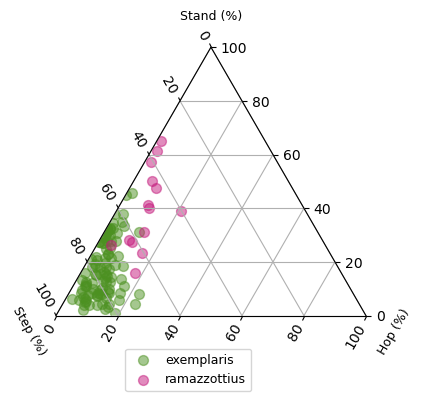

In [32]:
fig = plt.figure(figsize=(4,4),dpi=100,facecolor=(1,1,1,0))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

ax.scatter(stand_rear_con, step_rear_con, hop_rear_con,
           color=con_color,s=50,alpha=0.5,label=control)
ax.scatter(stand_rear_exp, step_rear_exp, hop_rear_exp,
           color=exp_color,s=50,alpha=0.5,label=experimental)

ax.set_tlabel("Stand (%)", fontsize=tick_fontsize)
ax.set_llabel("Step (%)", fontsize=tick_fontsize)
ax.set_rlabel("Hop (%)", fontsize=tick_fontsize)

ax.grid()
# ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.55, -0.9, 0.5, 0.5) )# , loc='lower center') # 1.3 size
ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.15, -0.6, 0.5, 0.5) )# , loc='lower center') # 4 size

plt.show()

In [33]:
stand_lateral_exp = exp['% stand (lateral legs)'].values
stand_lateral_con = con['% stand (lateral legs)'].values

pentapod_exp = exp['% pentapod (lateral legs)'].values
pentapod_con = con['% pentapod (lateral legs)'].values

tetrapod_canonical_exp = exp['% tetrapod canonical (lateral legs)'].values
tetrapod_canonical_con = con['% tetrapod canonical (lateral legs)'].values

tetrapod_gallop_exp = exp['% tetrapod gallop (lateral legs)'].values
tetrapod_gallop_con = con['% tetrapod gallop (lateral legs)'].values

tetrapod_other_exp = exp['% tetrapod other (lateral legs)'].values
tetrapod_other_con = con['% tetrapod other (lateral legs)'].values

tetrapod_total_exp = exp['% tetrapod total (lateral legs)'].values
tetrapod_total_con = con['% tetrapod total (lateral legs)'].values

tripod_canonical_exp = exp['% tripod canonical (lateral legs)'].values
tripod_canonical_con = con['% tripod canonical (lateral legs)'].values

tripod_other_exp = exp['% tripod other (lateral legs)'].values
tripod_other_con = con['% tripod other (lateral legs)'].values

tripod_total_exp = exp['% tripod total (lateral legs'].values
tripod_total_con = con['% tripod total (lateral legs'].values

# 'total' here is pentapod + tetrapod + tripod
total_exp =  pentapod_exp + tetrapod_total_exp + tripod_total_exp
total_con =  pentapod_con + tetrapod_total_con + tripod_total_con

pentapod_percent_exp = pentapod_exp / total_exp
tetrapod_percent_exp = tetrapod_total_exp / total_exp
tripod_percent_exp = tripod_total_exp / total_exp
# print(pentapod_percent_exp + tetrapod_percent_exp + tripod_percent_exp)# testing OK

pentapod_percent_con = pentapod_con / total_con
tetrapod_percent_con = tetrapod_total_con / total_con
tripod_percent_con = tripod_total_con / total_con
# print(pentapod_percent_con + tetrapod_percent_con + tripod_percent_con)# testing OK


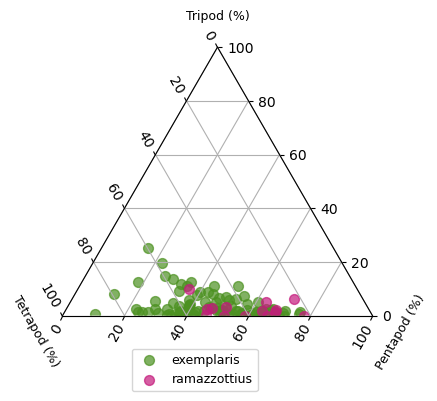

In [34]:
fig = plt.figure(figsize=(4,4),dpi=100,facecolor=(1,1,1,0))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

# total
# ax.scatter(pentapod_percent_con, tetrapod_percent_con, tripod_percent_con,c=con_color,s=10,label=control)
# ax.scatter(pentapod_percent_exp, tetrapod_percent_exp, tripod_percent_exp,c=exp_color,s=10,label=experimental)
# ax.set_tlabel("Pentapod (%)")
# ax.set_llabel("Tetrapod (%)")
# ax.set_rlabel("Tripod (%)")

# canonical
ax.scatter(tripod_canonical_con, tetrapod_canonical_con, pentapod_con, 
           color=con_color,s=50,alpha=0.7,label=control)
ax.scatter(tripod_canonical_exp, tetrapod_canonical_exp, pentapod_exp, 
           color=exp_color,s=50,alpha=0.7,label=experimental)
ax.set_tlabel("Tripod (%)", fontsize=tick_fontsize)
ax.set_llabel("Tetrapod (%)", fontsize=tick_fontsize)
ax.set_rlabel("Pentapod (%)", fontsize=tick_fontsize)

ax.grid()
# ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.35, -0.7, 0.5, 0.5) )#, loc='lower center') # 1.3 size
ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.15, -0.6, 0.5, 0.5) )# , loc='lower center') # 4 size

plt.show()

# compositional data = log ratio transform

In [35]:
# rear legs
rear_labs = ['stand','step','hop']
treatments = gait_summaries_df.treatment.values
control_ix = np.where(treatments == control)[0]
exp_ix = np.where(treatments == experimental)[0]
rear_percentages = np.hstack([[
    gait_summaries_df['% stand (rear legs)'].values,
    gait_summaries_df['% step (rear legs)'].values,
    gait_summaries_df['% hop (rear legs)'].values
                             ]])
# print(np.sum(rear_percentages,0)) # should all be 100 ... check!
rear_percentages_nozeros = cs.multiplicative_replacement(rear_percentages)
# print(np.sum(rear_percentages_nozeros,0)) # should still be 100-ish ... check!
rear_clr = cs.clr(rear_percentages_nozeros)

TypeError: list indices must be integers or slices, not str

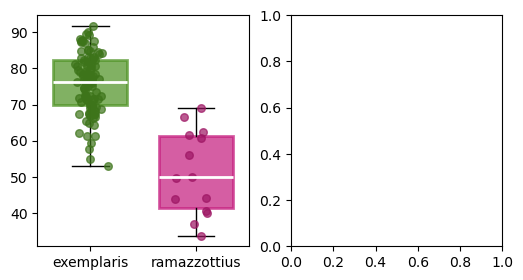

In [36]:
# REAR boxplot
rear_col = 1 # 0=stand, 1=step, 2=hop
from matplotlib.patches import Patch
f,[a1,a2] = plt.subplots(1,2,figsize=(6,3))
labels = [control,experimental]
rear_boxdata = [rear_percentages[rear_col][control_ix], rear_percentages[rear_col][exp_ix]]
a1,bp1=colorBoxplot(a1,rear_boxdata,[con_color,exp_color],labels, 30,0.8)
a1.set_ylabel('% ' + rear_labs[col])

rear_clr_boxdata = [rear_clr[col][control_ix], rear_clr[rear_col][exp_ix]]
a2,bp2=colorBoxplot(a2,rear_clr_boxdata,[con_color,exp_color],labels, 30,0.8)
a2.set_ylabel('CLR  '+ rear_labs[rear_col])

legend_elements = [Patch(facecolor=con_color, edgecolor=None,
                         label=control),
                  Patch(facecolor=exp_color, edgecolor=None,
                         label=experimental)]
a2.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))

plt.tight_layout()

pval, test = pairwiseStats(rear_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)
plt.show()



In [ ]:
# just CLR from above, as a violin plot
f,a = plt.subplots(1,1,figsize=(1.4,1.6), facecolor=(1,1,1,0),dpi=150)
labels = [control,experimental]
rear_boxdata = [rear_percentages[col][control_ix], rear_percentages[col][exp_ix]]
rear_clr_boxdata = [rear_clr[rear_col][control_ix], rear_clr[rear_col][exp_ix]]

# violinplot
a = gaitFunctions.colorViolinPlot(a,rear_clr_boxdata,[con_color,exp_color],labels,inner='box')

a.set_ylabel('rear ' + rear_labs[rear_col] + '\n(centered log ratio)')
pval, test = pairwiseStats(rear_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

# legend (outside of plot)
# legend_elements = [Patch(facecolor=con_color, edgecolor=None,
#                          label=control),
#                   Patch(facecolor=exp_color, edgecolor=None,
#                          label=experimental)]
# a.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))

a.set_xticks([1,2],[control[:3], experimental[:3]])

plt.show()



In [ ]:
# LATERAL legs
lateral_percentages = np.hstack([[
    gait_summaries_df['% stand (lateral legs)'].values,
    gait_summaries_df['% pentapod (lateral legs)'].values,
    gait_summaries_df['% tetrapod canonical (lateral legs)'].values,
    gait_summaries_df['% tetrapod gallop (lateral legs)'].values,
    gait_summaries_df['% tetrapod other (lateral legs)'].values,
    gait_summaries_df['% tripod canonical (lateral legs)'].values,
    gait_summaries_df['% tripod other (lateral legs)'].values,
    gait_summaries_df['% other (lateral legs)'].values
                             ]])
lat_labs = ['stand','pentapod','tetrapod canonical','tetrapod gallop','tetrapod other',
       'tripod canonical','tripod other',' other']

# print(np.sum(lateral_percentages,0)) # should all be 100 ... check!
lateral_percentages_nozeros = cs.multiplicative_replacement(lateral_percentages)
# print(np.sum(lateral_percentages_nozeros,0)) # should still be 100-ish ... check!
lateral_clr = cs.clr(lateral_percentages_nozeros)



In [ ]:
# LATERAL boxplot a:  % for ex vs. ram, 2: clr for ex vs. ram
from matplotlib.patches import Patch
lat_col = 2 # 0=stand 1=pentapod 2=tetrapod canonical 3=tetrapod gallop 4=tetrapod other
#         5=tripod canonical 6=tripod other 7=other
f,[a1,a2] = plt.subplots(1,2,figsize=(6,3))
lateral_boxdata = [lateral_percentages[collat_col][control_ix], lateral_percentages[colat_coll][exp_ix]]
a1,bp1=colorBoxplot(a1,lateral_boxdata,[con_color,exp_color],[control,experimental],30,0.8)
a1.set_ylabel('% ' + lat_labs[lat_col])

lateral_clr_boxdata = [lateral_clr[lat_col][control_ix], lateral_clr[lat_col][exp_ix]]
a2,bp2=colorBoxplot(a2,lateral_clr_boxdata,[con_color,exp_color],[control,experimental],30,0.8)
a2.set_ylabel('CLR  '+ lat_labs[lat_col])

pval, test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

legend_elements = [Patch(facecolor=con_color, edgecolor=None,
                         label=control),
                  Patch(facecolor=exp_color, edgecolor=None,
                         label=experimental)]
# a2.set_ylim([-3,2])
a2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 0.2, 0.5, 0.5))
plt.tight_layout()
plt.show()



In [ ]:
# just CLR from above, as a violin plot
f,a = plt.subplots(1,1,figsize=(1.4,1.6), facecolor=(1,1,1,0),dpi=150)

# violinplot
a = gaitFunctions.colorViolinPlot(a,lateral_clr_boxdata,[con_color,exp_color],labels,inner='box')

a.set_ylabel(lat_labs[col] + '\n(centered log ratio)')
lat_clr_pval, lat_clr_test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(lat_clr_pval,6), 'by', lat_clr_test)

# legend (outside of plot)
# legend_elements = [Patch(facecolor=con_color, edgecolor=None,
#                          label=control),
#                   Patch(facecolor=exp_color, edgecolor=None,
#                          label=experimental)]
# a.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))

a.set_xticks([1,2],[control, experimental[:3]])

plt.show()

# collected plots for figure

In [ ]:
# ternary plot at correct size
fig = plt.figure(figsize=(3.8,3.8),dpi=100,facecolor=(1,1,1,0)) # was 1.94,1.94
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)
elab = 'Ram'

ax.scatter(step_rear_con, hop_rear_con, stand_rear_con,
           color=con_color,s=50,alpha=0.5,label=control[:3])
ax.scatter(step_rear_exp, stand_rear_exp, hop_rear_exp,
           color=exp_color,s=50,alpha=0.5,label=elab)

ax.set_tlabel("Step (%)", fontsize=axis_fontsize*1.94)
ax.set_llabel("Stand (%)", fontsize=axis_fontsize*1.94)
ax.set_rlabel("Hop (%)", fontsize=axis_fontsize*1.94)

ax.grid()
# ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.83, 0.55, 0.5, 0.5)) # 1.9 size
ax.legend(fontsize=tick_fontsize*1.94, bbox_to_anchor=(0.73, 0.55, 0.5, 0.5)) # 3.8 size

plt.show()

In [ ]:
print(comp_labels)

In [ ]:
# rear CLR plot at correct size
f,a = plt.subplots(1,1,figsize=(1.42,1.94), facecolor=(1,1,1,0), dpi=300)
medsize=2
vwidth=0.8
# violinplot
a = gaitFunctions.colorViolinPlot(a,rear_clr_boxdata,[con_color,exp_color],labels,inner='box',
                                  medsize=medsize, vwidth=0.8)

a.set_ylabel('rear ' + rear_labs[rear_col] + '\n(centered log ratio)')
rear_clr_pval, rear_clr_test = pairwiseStats(rear_clr_boxdata)
a.set_xticks([1,2],[control[:3], 'Ram'])

# udpate pvalues to include clr
pval_dict['% step (rear legs)'] = rear_clr_pval
comp_pvals = [pval_dict[x] for x in comp_labels]
adj_comp_pvals = correctMultipleTests(comp_pvals,'by')
adj_comp_pvals_dict = dict(zip(comp_labels, adj_comp_pvals))
print('p = ', np.round(adj_comp_pvals_dict['% step (rear legs)'],6), 'by', rear_clr_test)

plt.show()

In [ ]:
diffcols = ['Body Length (mm)', # 0
            'Body Width/Length Ratio', # 1
           'bodylength per step (lateral legs)', # 2
           'Bearing change (deg) / sec cruising', # 3
           'Stops / sec', # 4
           'Stance duration (lateral legs)', # 5
            'Swing duration (lateral legs)', # 6
            'bodylength per step (lateral legs)', # 7
            'Stance duration (rear legs)', # 8
            '% step (rear legs)' # 9
           ]

In [ ]:
print(collabs[diffcols[0]])

In [ ]:
# violin plots
f,axes=plt.subplots(1,3,figsize=(5.7,2),dpi=300)
[a1,a2,a3] = axes

axcols = [diffcols[3], diffcols[2], diffcols[5]]
axlabs = [collabs[x] for x in axcols]

con_lab = control
exp_lab = experimental

medsize = 2
vwidth = 0.8

for i, ax in enumerate([a1,a2,a3]):
    axcol = axcols[i]
    axdf = getDfForCol(axcol,[path_summaries_df,step_summaries_df,gait_summaries_df])
    axdf['Condition'] = np.where(axdf['treatment'] == control, 0, 1)
    condata = axdf[axdf['Condition']==0][axcol].values
    expdata = axdf[axdf['Condition']==1][axcol].values
    condata = gaitFunctions.omitNan(condata)
    expdata = gaitFunctions.omitNan(expdata)
    ax = gaitFunctions.colorViolinPlot(ax,[condata,expdata],[con_color,exp_color],
                                  [con_lab,exp_lab],inner='box',medsize=medsize,vwidth=vwidth,pointcolor=None)
    ax.set_ylabel(axlabs[i])
    ax.set_xticks([1,2],[control[:3], 'Ram'])
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    print(axcol, '-> p = ', adj_pval_dict[axcol], test_dict[axcol])
    
plt.tight_layout()
plt.show()